In [1]:
# SPFDM Assignment 2
# Luuk Oudshoorn and Willem-Jan de Voogd
# Fall 2020

In [2]:
import time
import numpy as np
import pandas as pd
import datetime as dt
from glob import glob
from scipy.interpolate import interp1d

# Import some of the basis required functions
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
from scipy import interpolate
from scipy.stats import norm
from joblib import Parallel, delayed
import networkx as nx
from scipy.stats import norm
import scipy as sp
import matplotlib.pyplot as plt
import ffn 
from matplotlib import collections as matcoll
%matplotlib inline

Exercise 10 (Stochastic  volatility).
Simulate the paths to maturity T= 1 year. Use the SABR model.
1.  Plot a single path and look if you can observe a volatility clustering.
2.  Plot  histograms  of  log-returns  and  compare  them  to  the  normal  
distribution with the same mean and variance.  Observe the skewness and fattails.

0


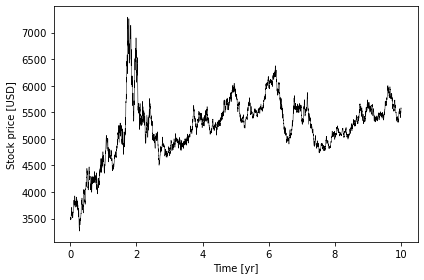

In [65]:
class MonteCarlo():
    def __init__(self,Npaths, Nsteps, T, F, sigma, alpha, beta, rho, K = 3300, rf=None):
        """Function initialization like in the binomial tree model. 
           Predominantly fixed values"""
        """F is the initial forward rate, sigma the initial stochastic volatility."""
        # If we do not call the function with a value, 
        # initialize at the "standard" numbers
        if rf == 0:
            self.rf = rf
        elif not rf:
            self.rf = np.log((1+0.005/4)**4)
        else:
            self.rf = rf
        self.S0 = F*np.exp(-self.rf*T)
        self.F0 = F
        self.sigma0 = sigma
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.K     = K
        self.Npaths = Npaths
        self.Nsteps = Nsteps
        self.T = T
        self.dT = T/Nsteps
        print(self.rf)
        
    def propagate(self,ft_1,st_1):
        """Equate the monte carlo iteration as function of location xt"""
        """ft and st are, respectively, the forward rate and the stochastic volatility at time t"""
        
        N = 1 if type(ft_1)==np.float64 else len(ft_1)
        # Generate Correlated Brownian motions
        x = np.random.randn(N)
        e = np.sqrt(1-self.rho**2) * np.random.randn(N)
        y = self.rho*x+e
        # Simulate standard deviations and forward rates
        st = st_1 + self.alpha*st_1*np.sqrt(self.dT)*x 
        ft = ft_1 + st*ft_1**self.beta*self.rho*np.sqrt(self.dT)*y
        return ft, st

    def simulate(self):
        """Iterate through the MC process for N steps and 1 path"""
        """ft and st are, respectively, the forward rate and the stochastic volatility at time t"""
        ft = np.zeros(self.Nsteps)
        st = np.zeros(self.Nsteps)
        prices = np.zeros(self.Nsteps)
        # Initialize at start value
        ft[0] = self.F0
        st[0] = self.sigma0
        prices[0] = self.S0
        
        
        for i in range(self.Nsteps-1):
            # propagate prices
            ft[i+1], st[i+1] = self.propagate(ft[i], st[i])
            prices[i+1] = ft[i+1]*np.exp(-self.rf*(self.T - (i+1)*self.dT))
        return prices
        
    def plot_single(self, filename=None):
        """Plot a single realization"""
        prices = self.simulate()
        timearr = np.arange(0,self.T,self.dT)
        plt.plot(timearr,prices,color='black',lw=0.5)
        # plot horitontal line at long term mean
#         plt.axhline(self.ltm,ls='--',color='black',lw=1)
        plt.xlabel('Time [yr]')
        plt.ylabel('Stock price [USD]')
        plt.tight_layout()
        if filename:
            plt.savefig(filename)
        plt.show()
        
    def simulate_many(self):
        """Simulate Npaths for Nsteps"""
        """ft and st are, respectively, the forward rate and the stochastic volatility at time t"""
        ft = np.zeros((self.Npaths, self.Nsteps))
        st = np.zeros((self.Npaths, self.Nsteps))
        prices = np.zeros((self.Npaths, self.Nsteps))
        # Same as before but now a whole matrix with N paths
        ft[:,0] = self.F0
        st[:,0] = self.sigma0
        prices[:,0] = self.S0
        for i in range(self.Nsteps-1):
            ft[:,i+1], st[:,i+1] = self.propagate(ft[:,i], st[:,i])
            prices[:,i+1] = ft[:,i+1]*np.exp(-self.rf*(self.T - (i+1)*self.dT))
        return prices 
        
    def plot_many(self, logreturns=True):
        """Make a plot of the overall distribution and also plot the resulting PDF of final 
           prices."""
        prices = self.simulate_many()
        if logreturns==True:
            P = np.diff(np.log(prices))
            timearr = np.arange(self.dT,self.T,self.dT)
        else: 
            P = prices
            timearr = np.arange(0,self.T,self.dT)
        fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]},figsize=(8,1.7))
        for i in range(self.Npaths-1):
            a0.plot(timearr,P[i,:],color='black',lw=0.2)
        a0.plot(timearr,P[i,:],color='green',lw=1.0)
        a0.set_xlabel('Time [yr]')
        a0.set_ylabel('Stock price [USD]')
        
        a1.hist(P[:,-1],bins=100, color='gray', density=True)
        mean,std=norm.fit(P[:,-1])
        x = np.linspace(-0.015, 0.015, 100)
        y = norm.pdf(x, mean, std)
        a1.plot(x, y)
        a1.set_xticks([])
        a1.set_yticks([])
        a0.set_rasterized(True)
        fig.tight_layout(pad=-0.3)
        plt.savefig('manyMCtracks_PDF.png', dpi=400,bbox_inches='tight')
        plt.show()
        
    def option_price(self, optiontype='call'):
        """Equate option price by taking option value for each path, averaging and discounting back 
           to present day value using risk free rate. """
        # Get prices 
        prices = self.simulate_many()
        # Get final prices
        finalprices = prices[:,-1]
        # calculate option values
        if optiontype == 'call':
            optionvalues = np.max(np.vstack((np.zeros(len(finalprices)),finalprices-self.K)),axis=0)
        elif optiontype == 'put':
            optionvalues = np.max(np.vstack((np.zeros(len(finalprices)),self.K-finalprices)),axis=0)
        optionvalue = np.mean(optionvalues)
        # Discount to present value
        optionvalue = np.exp(-self.rf*self.T) * optionvalue
        return optionvalue

MC = MonteCarlo(4000,5000,T=10,F=3500, sigma=0.2, alpha=0.5, beta=1, rho=-0.7,K=3300, rf=0)
MC.plot_single()

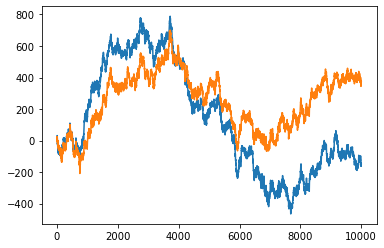

In [43]:
np.random.seed(42)
N=10000
sqrtT = np.sqrt(50)
x = np.random.randn(N)
rho = .85
std = np.sqrt(1-rho**2)
e = np.random.randn(N) * std
y = rho*x+e
x=x*sqrtT
y=y*sqrtT
X = np.cumsum(x)
Y = np.cumsum(y)
plt.plot(X)
plt.plot(Y)

In [53]:
np.mean(x*y)/(np.std(x)*np.std(y))

0.8493227010920675